In [1]:
import os
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np
from functools import partial
import dproc, sgutil
import matplotlib.pyplot as plt
import seaborn as sns

# Data Acquisition

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if not os.path.exists(files['train']):
    !kaggle competitions download -c playground-series-s4e11
    !unzip playground-series-s4e11.zip -d data
    !rm playground-series-s4e11.zip

if not os.path.exists(files['var_pkl']):
    df_type = dproc.merge_type_df([
        pl.scan_csv(files[i]).pipe(dproc.get_type_df) for i in ['train', 'test']
    ])
    pl_type = dproc.get_type_pl(df_type)
    s_type = pd.Series(pl_type, name='pl_type')
    df_var = pd.concat([
        df_type.drop(columns='dtype'),
        s_type,
        s_type.astype('str').rename('dtype'),
        pd.Series(['Target'], index=['Depression'], name='Description')
    ], axis=1)
    df_var.to_pickle(files['var_pkl'])
    pl.scan_csv(files['train'], schema_overrides=df_var['pl_type'].to_dict()).sink_parquet(files['train_parquet'])
    pl.scan_csv(files['test'], schema_overrides=df_var['pl_type'].to_dict()).sink_parquet(files['test_parquet'])

df_var = pd.read_pickle(files['var_pkl']).assign(src="org")
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_var

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src
Academic Pressure,1.00,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,NaN,org
Age,18.00,60.0,0.0,234500.0,43.5,True,True,True,True,Float32,Float32,NaN,org
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,NaN,org
City,NaN,NaN,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,NaN,org
Degree,NaN,NaN,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,NaN,org
Depression,0.00,1.0,0.0,140700.0,2.0,True,True,True,True,Int8,Int8,Target,org
Dietary Habits,NaN,NaN,9.0,234491.0,23.5,True,True,True,True,Categorical,Categorical,NaN,org
Family History of Mental Illness,NaN,NaN,0.0,234500.0,2.0,True,True,True,True,Categorical,Categorical,NaN,org
Financial Stress,1.00,5.0,4.0,234496.0,5.5,True,True,True,True,Float32,Float32,NaN,org
Gender,NaN,NaN,0.0,234500.0,2.0,True,True,True,True,Categorical,Categorical,NaN,org


# Global Variables & Common Modules

In [3]:
from sklearn.metrics import accuracy_score
target = 'Depression'
sc = sgutil.SGCache('img', 'result')

# Polars Processing

In [4]:
# End of Polars Processing
df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')

In [5]:
X_all = df_test.columns.to_list()
n_train, n_test = len(df_train), len(df_test)
(n_train, n_test, n_train / (n_train + n_test))

(140700, 93800, 0.6)

# Train / Test Difference

0.5008868837354181


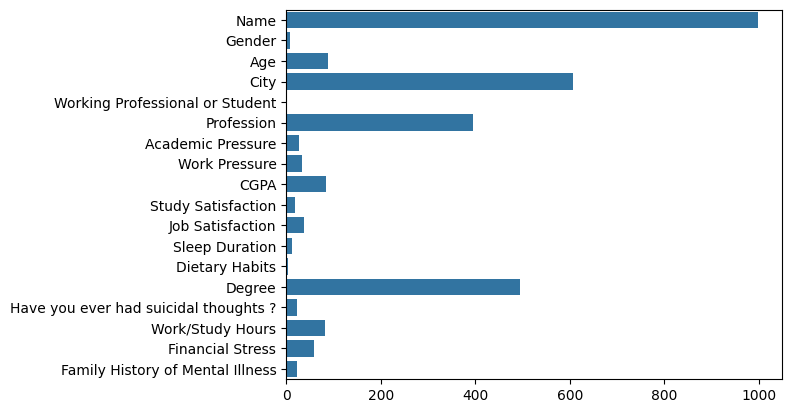

In [6]:
def get_diffs_with_lgb():
    from sklearn.model_selection import ShuffleSplit, cross_validate
    import lightgbm as lgb
    X_cat = df_var.loc[df_var.index.isin(X_all) & (df_var['dtype'] == 'Categorical')].index.tolist()
    X_cont = df_var.loc[df_var.index.isin(X_all) & (df_var['dtype'] == 'Float32')].index.tolist()
    X_lgb = X_cont + X_cat
    
    result = pd.concat([
        df_train[X_all].assign(
            is_train=True
        ),
        df_test[X_all].assign(
            **{i: dproc.rearrange_cat(df_test[i], df_train[i].dtype, lambda cats, val: -1) for i in X_cat}, # test에 train 없는 categories를 없애줍니다.
            is_train=False
        )
    ], axis=0).pipe(
        lambda x: cross_validate(
            lgb.LGBMClassifier(verbose=-1), x[X_all], x['is_train'], cv=ShuffleSplit(n_splits=1, train_size=0.6, random_state=123), 
            return_estimator=True, params={'categorical_feature':X_cat}, scoring='roc_auc'
        )
    )
    return result['estimator'][0].feature_importances_, result['test_score'][0]
feature_importance, roc_auc = sc.cache_result("train_test diff", get_diffs_with_lgb)
sns.barplot(x=feature_importance, y=X_all)
print(roc_auc)

In [7]:
X_cat = df_var.loc[df_var.index.isin(X_all) & (df_var['dtype'] == 'Categorical')].index.tolist()

In [8]:
sc.cache_result('Only_Test_Category',
    lambda : pd.concat([
        df_train[X_cat].apply(lambda x: set(x)).rename('train'),
        df_test[X_cat].apply(lambda x: set(x)).rename('test')
    ], axis=1).apply(
        lambda x: x['test'] - x['train'], axis=1
    )
)

City                                     {No.12, Chemist, San Vasai-Virar, Less than 5 ...
Degree                                   {B.H, M.B.Ed, I.Ed, Moham, Eshita, Mechanical ...
Dietary Habits                           {Soham, Raghav, Vivaan, Naina, 5 Unhealthy, Ed...
Family History of Mental Illness                                                        {}
Gender                                                                                  {}
Have you ever had suicidal thoughts ?                                                   {}
Name                                     {Anishwarya, Kartush, Anaghav, Sita, Yashi, Ma...
Profession                               {24th, Samar, ME, No, Surat, 3M, MD, B.Pharm, ...
Sleep Duration                           {50-75 hours, 9-10 hours, Meerut, 60-65 hours,...
Working Professional or Student                                                         {}
dtype: object

In [9]:
df_city_freq = sc.cache_result('City_Freq',
    lambda : pd.concat([
        df_train['City'].value_counts().rename('train'),
        df_test['City'].value_counts().rename('test')
    ], axis=1)
)
df_city_freq.loc[df_city_freq.isna().any(axis=1)]

,train,test
City,,
Mihir,7.0,NaN
Nandini,4.0,NaN
Mahi,3.0,NaN
Harsha,3.0,NaN
Molkata,2.0,NaN
...,...,...
Avni,NaN,1.0
Mhopal,NaN,1.0
Less than 5 hours,NaN,1.0


City에는 노이즈가 존재합니다. 이들을 제거할 필요가 있다고 봅니다.

In [10]:
def get_city_proc():
    city_cat = pd.CategoricalDtype(['Noise'] + df_city_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 10]).index.tolist())
    return lambda x: dproc.rearrange_cat(x, city_cat, lambda cats, x: x if x in cats else 0).fillna('Noise')
city_proc = get_city_proc()

In [11]:
df_dietary_freq = sc.cache_result('Dietary Habits',
    lambda : pd.concat([
        df_train['Dietary Habits'].value_counts().rename('train'),
        df_test['Dietary Habits'].value_counts().rename('test')
    ], axis=1)
)
df_dietary_freq.loc[df_dietary_freq.isna().any(axis=1)]

,train,test
Dietary Habits,,
Yes,2.0,NaN
No Healthy,1.0,NaN
Class 12,1.0,NaN
Vegas,1.0,NaN
M.Tech,1.0,NaN
Electrician,1.0,NaN
Hormonal,1.0,NaN
Mihir,1.0,NaN
Less than Healthy,1.0,NaN


In [12]:
def get_dietary_proc():
    dietary_cat = pd.CategoricalDtype(['Noise'] + df_dietary_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 10]).index.tolist())
    to_healty = ['Yes', 'More Healthy', '5 Healthy']
    to_unhealty = ['No', 'No Healthy', 'Less Healthy', 'Less than Healthy', '5 Unhealthy']
    return lambda x: dproc.rearrange_cat(x, dietary_cat, lambda cats, x: x if x in cats else 2 if x in to_healty else 1 if x in to_unhealty else 0).fillna('Noise')
dietary_proc = get_dietary_proc()

In [13]:
df_prof_freq = sc.cache_result('Profession_Freq',
    lambda : pd.concat([
        df_train['Profession'].value_counts().rename('train'),
        df_test['Profession'].value_counts().rename('test')
    ], axis=1)
)
display(df_prof_freq.loc[df_prof_freq.isna().any(axis=1)])
def get_prof_proc():
    prof_cat = pd.CategoricalDtype(['Noise', 'Unknown'] + df_prof_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 10]).index.tolist())
    return lambda x: dproc.rearrange_cat(x, prof_cat, lambda cats, x: x if x in cats else 0).fillna('Unknown')
prof_proc = get_prof_proc()

,train,test
Profession,,
Academic,5.0,NaN
BCA,3.0,NaN
MBA,2.0,NaN
Dev,1.0,NaN
BE,1.0,NaN
Family Consultant,1.0,NaN
Visakhapatnam,1.0,NaN
Pranav,1.0,NaN
Moderate,1.0,NaN


In [14]:
df_sleep_freq = sc.cache_result('Sleep_Freq',
    lambda : pd.concat([
        df_train['Sleep Duration'].value_counts().rename('train'),
        df_test['Sleep Duration'].value_counts().rename('test')
    ], axis=1)
)
display(df_sleep_freq.loc[df_sleep_freq.isna().any(axis=1)])
def get_sleep_proc():
    dietary_cat = pd.CategoricalDtype(['Noise'] + df_sleep_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 20]).index.tolist())
    sleep_noise = df_sleep_freq.loc[df_sleep_freq.sum(axis=1) <= 20].index.to_series()
    s_hours = sleep_noise.str.findall('[0-9]+')
    repl_dict = pd.cut(s_hours.loc[s_hours.apply(lambda x: len(x) > 0)].apply(lambda x:[int(i) for i in x]).apply(
        lambda x: 8 if len(x) == 2 and x[0] > x[1] else np.mean(x)
    ), bins=[-np.inf, 5, 7, 8, 20, np.inf], labels= [1, 2, 3, 4, 0], right=False).astype(int).to_dict()
    return lambda x: dproc.rearrange_cat(x, dietary_cat, lambda cats, x: x if x in cats else repl_dict.get(x, 0)).fillna('Noise')
sleep_proc = get_sleep_proc()

,train,test
Sleep Duration,,
6-8 hours,4.0,NaN
No,4.0,NaN
10-11 hours,2.0,NaN
Sleep_Duration,2.0,NaN
45,2.0,NaN
45-48 hours,1.0,NaN
Work_Study_Hours,1.0,NaN
49 hours,1.0,NaN
Pune,1.0,NaN


In [15]:
df_degree_freq = sc.cache_result('Degree_Freq',
    lambda : pd.concat([
        df_train['Degree'].value_counts().rename('train'),
        df_test['Degree'].value_counts().rename('test')
    ], axis=1)
)
display(df_degree_freq.loc[df_degree_freq.isna().any(axis=1)])
def get_degree_proc():
    degree_cat = pd.CategoricalDtype(['Noise'] + df_degree_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 20]).index.tolist())
    return lambda x: dproc.rearrange_cat(x, degree_cat, lambda cats, x: x if x in cats else 0).fillna('Noise')
degree_proc = get_degree_proc()

,train,test
Degree,,
UX/UI Designer,4.0,NaN
Kalyan,3.0,NaN
MEd,2.0,NaN
P.Com,2.0,NaN
Jhanvi,2.0,NaN
...,...,...
Pune,NaN,1.0
Bian,NaN,1.0
Kavya,NaN,1.0


In [16]:
df_train['Name'].value_counts().pipe(lambda x: x.loc[x > 20])

df_name_freq = sc.cache_result('Name_Freq',
    lambda : pd.concat([
        df_train['Name'].value_counts().rename('train'),
        df_test['Name'].value_counts().rename('test')
    ], axis=1)
)
display(df_name_freq.loc[df_name_freq.isna().any(axis=1)])
def get_name_proc():
    name_cat = pd.CategoricalDtype(['Noise'] + df_name_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 20]).index.tolist())
    return lambda x: dproc.rearrange_cat(x, name_cat, lambda cats, x: x if x in cats else 0).fillna('Noise')
name_proc = get_name_proc()

,train,test
Name,,
Aarash,3.0,NaN
Tarsh,3.0,NaN
Shivvi,2.0,NaN
Prishti,2.0,NaN
Pradhya,2.0,NaN
...,...,...
Aarhar,NaN,1.0
AHM,NaN,1.0
Managan,NaN,1.0


City 뿐만 아니라 Dietary Habits, Degree, Profession, Sleep Duration, Name 에서 두드러지는 저빈도 범주가 등장했습니다. 이를 처리하기 위한 루틴을 만들어 왔습니다.

In [17]:
# 카테고리 처리루틴을 종합하고 train에 적용합니다.
def cat_procs(df):
    cat_procs_list = [
        ('City', city_proc, 'City에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.'),
        ('Dietary Habits', dietary_proc, 'Dietary Habits에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, 빈도가 10 미만은 Noise 처리합니다.'),
        ('Profession', prof_proc, 'Profession에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.'),
        ('Sleep Duration', sleep_proc, 'Sleep Duration에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, 빈도가 10 미만은 Noise 처리합니다.'),
        ('Degree', degree_proc, 'Degree에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, 빈도가 10 미만은 Noise 처리합니다.'),
        ('Name', name_proc, 'Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.'),
    ]
    var_list, proc_list = list(), list()
    for v, proc, desc in cat_procs_list:
        proc_list.append(proc(df_train[v]).rename(v + '_R'))
        var_list.append(['cat_procs', proc_list[-1], desc, 'Categorical'])
    return dproc.get_type_vars(var_list), pd.concat(proc_list, axis=1)
if 'City_R' not in df_train.columns:
    df_cat_proc_var, df_train_cat_proc = sc.cache_result('train_cat_procs', lambda : cat_procs(df_train))
    df_train = df_train.join(df_train_cat_proc)
    df_var = pd.concat([df_var, df_cat_proc_var])
df_cat_proc_var

,src,Description,dtype,na,n_unique,count
var,,,,,,
City_R,cat_procs,City에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.,Categorical,0,31,140700
Dietary Habits_R,cat_procs,Dietary Habits에서 train과 test에서 최대한 유사 빈도의 카테고리...,Categorical,0,4,140700
Profession_R,cat_procs,Profession에서 train과 test에서 빈도가 10 미만은 Noise 처리...,Categorical,0,38,140700
Sleep Duration_R,cat_procs,Sleep Duration에서 train과 test에서 최대한 유사 빈도의 카테고리...,Categorical,0,5,140700
Degree_R,cat_procs,"Degree에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, ...",Categorical,0,28,140700
Name_R,cat_procs,Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.,Categorical,0,218,140700


In [18]:
# 카테고리 처리루틴 후에 test에만 등장하는 카테고리가 있는지를 살펴봅니다.
sc.cache_result('Only_Test_Category_After_cat_procs',
    lambda : pd.concat([
        df_train_cat_proc.apply(lambda x: set(x)).rename('train'),
        cat_procs(df_test)[1].apply(lambda x: set(x)).rename('test')
    ], axis=1).apply(
        lambda x: x['test'] - x['train'], axis=1
    )
)

City_R              {}
Dietary Habits_R    {}
Profession_R        {}
Sleep Duration_R    {}
Degree_R            {}
Name_R              {}
dtype: object

# Target Distribution

In [19]:
df_train[target].value_counts().pipe(lambda x: pd.concat([x, (x / x.sum()).rename('ratio')], axis=1))

,count,ratio
Depression,,
0,115133,0.818287
1,25567,0.181713


무조건 Depression이라고 예측을 해도 0.818 의 정확도를 얻을 수 있습니다.

# Categorical Variables

In [20]:
X_cat = df_var.query('src == "cat_procs"').index.to_list()
X_bool = df_var.query('n_unique == 2 and Description != "Target"').index.to_list()
np.array(X_cat), np.array(X_bool)
X_cat_all = X_cat + X_bool

## Chi2 Independent Test with target

In [21]:
from scipy.stats import chi2_contingency
df_chi2_result = sc.cache_result('Chi2_test_result',
    lambda : df_train[X_cat_all].apply(lambda x: chi2_contingency(pd.crosstab(x, df_train[target]))).apply(lambda x: pd.Series([x[0], x[1]], index=['stat', 'pvalue']))
).T.sort_values('stat', ascending=False)
df_chi2_result

,stat,pvalue
Profession_R,42058.339673,0.000000e+00
Working Professional or Student,38157.585828,0.000000e+00
Have you ever had suicidal thoughts ?,17142.055358,0.000000e+00
Degree_R,13063.034997,0.000000e+00
Name_R,4498.648616,0.000000e+00
Dietary Habits_R,3243.557753,0.000000e+00
Sleep Duration_R,1195.719459,1.349409e-257
City_R,1055.176825,1.134086e-202
Family History of Mental Illness,38.227325,6.296449e-10
Gender,9.289548,2.304650e-03


## Mode/Accuracy

In [22]:
# 그룹별 최빈값으로 예측했을 때의 정확도를 구합니다.
def mode_accuracy():
    s_acc_list = list()
    for i in X_cat_all:
        s_target_mode = df_train.groupby(i, observed=True)[target].apply(lambda x: x.mode()[0])
        s_acc_list.append(accuracy_score(df_train[target], df_train[i].map(s_target_mode)))
    return pd.Series(s_acc_list, index=X_cat_all, name='mode/accuracy')
s_mode_accuracy = sc.cache_result('Mode Accuracy', mode_accuracy)
s_mode_accuracy

City_R                                   0.818287
Dietary Habits_R                         0.818287
Profession_R                             0.836482
Sleep Duration_R                         0.818287
Degree_R                                 0.820910
Name_R                                   0.818287
Family History of Mental Illness         0.818287
Gender                                   0.818287
Have you ever had suicidal thoughts ?    0.818287
Working Professional or Student          0.852196
Name: mode/accuracy, dtype: float64

## Chi2 Independent Test between features

In [23]:
from scipy.spatial.distance import pdist, squareform
chi2_tab = sc.cache_result('Chi2_test_with_features',
    lambda : pdist(df_train[X_cat_all].T, lambda u, v: chi2_contingency(pd.crosstab(u, v))[0])
)
pd.DataFrame(squareform(chi2_tab), index=X_cat_all, columns =X_cat_all)

,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R,Family History of Mental Illness,Gender,Have you ever had suicidal thoughts ?,Working Professional or Student
City_R,0.000000,1058.396887,11030.335783,532.831952,13282.602096,100433.962350,217.077020,1314.771425,168.585714,1865.532343
Dietary Habits_R,1058.396887,0.000000,1575.356771,86.938022,1357.855499,4433.494132,4.318453,210.096721,615.498831,397.128570
Profession_R,11030.335783,1575.356771,0.000000,652.189054,581573.375189,91764.840894,95.958660,1050.729087,3310.598264,98560.119999
Sleep Duration_R,532.831952,86.938022,652.189054,0.000000,513.033711,3378.816317,4.028703,11.074140,189.903973,107.506921
Degree_R,13282.602096,1357.855499,581573.375189,513.033711,0.000000,82150.671941,66.033101,862.428119,1218.514459,6632.736693
Name_R,100433.962350,4433.494132,91764.840894,3378.816317,82150.671941,0.000000,946.086905,138020.297942,1198.880599,7203.710985
Family History of Mental Illness,217.077020,4.318453,95.958660,4.028703,66.033101,946.086905,0.000000,33.736193,12.103271,23.967716
Gender,1314.771425,210.096721,1050.729087,11.074140,862.428119,138020.297942,33.736193,0.000000,16.562594,6.202542
Have you ever had suicidal thoughts ?,168.585714,615.498831,3310.598264,189.903973,1218.514459,1198.880599,12.103271,16.562594,0.000000,2666.502431
Working Professional or Student,1865.532343,397.128570,98560.119999,107.506921,6632.736693,7203.710985,23.967716,6.202542,2666.502431,0.000000


In [24]:
# Profession과 Working Professional or Student과 빈도수를 구해봅니다.
sc.cache_result('Conti_Professional_R',
    lambda : df_train.groupby('Working Professional or Student', observed=False)['Profession_R'].apply(lambda x: x.value_counts()).unstack()
)

,Noise,Unknown,Teacher,Content Writer,Architect,Consultant,HR Manager,Pharmacist,Doctor,Business Analyst,...,Civil Engineer,UX/UI Designer,Digital Marketer,Accountant,Finanancial Analyst,Mechanical Engineer,Graphic Designer,Research Analyst,Investment Banker,Student
Working Professional or Student,,,,,,,,,,,,,,,,,,,,,
Working Professional,43,8763,24900,7812,4362,4229,4022,3891,3253,3161,...,1469,1451,1369,1339,1329,1177,1163,690,393,4
Student,0,27867,6,2,8,0,0,2,2,0,...,1,1,3,0,0,0,0,0,0,3


Profession과 Working Professional or Student 에는 일관성이 없는 데이터들이 약간씩 존재합니다. 

In [25]:
X_cont = df_var.loc[(df_var['Description'] != 'Target') & (df_var['dtype'] == 'Float32')].index.to_list()
df_var.loc[X_cont]

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src
Academic Pressure,1.00,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,NaN,org
Age,18.00,60.0,0.0,234500.0,43.5,True,True,True,True,Float32,Float32,NaN,org
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,NaN,org
Financial Stress,1.00,5.0,4.0,234496.0,5.5,True,True,True,True,Float32,Float32,NaN,org
Job Satisfaction,1.00,5.0,46684.0,187816.0,6.0,True,True,True,True,Float32,Float32,NaN,org
Study Satisfaction,1.00,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,NaN,org
Work Pressure,1.00,5.0,46696.0,187804.0,6.0,True,True,True,True,Float32,Float32,NaN,org
Work/Study Hours,0.00,12.0,0.0,234500.0,13.0,True,True,True,True,Float32,Float32,NaN,org


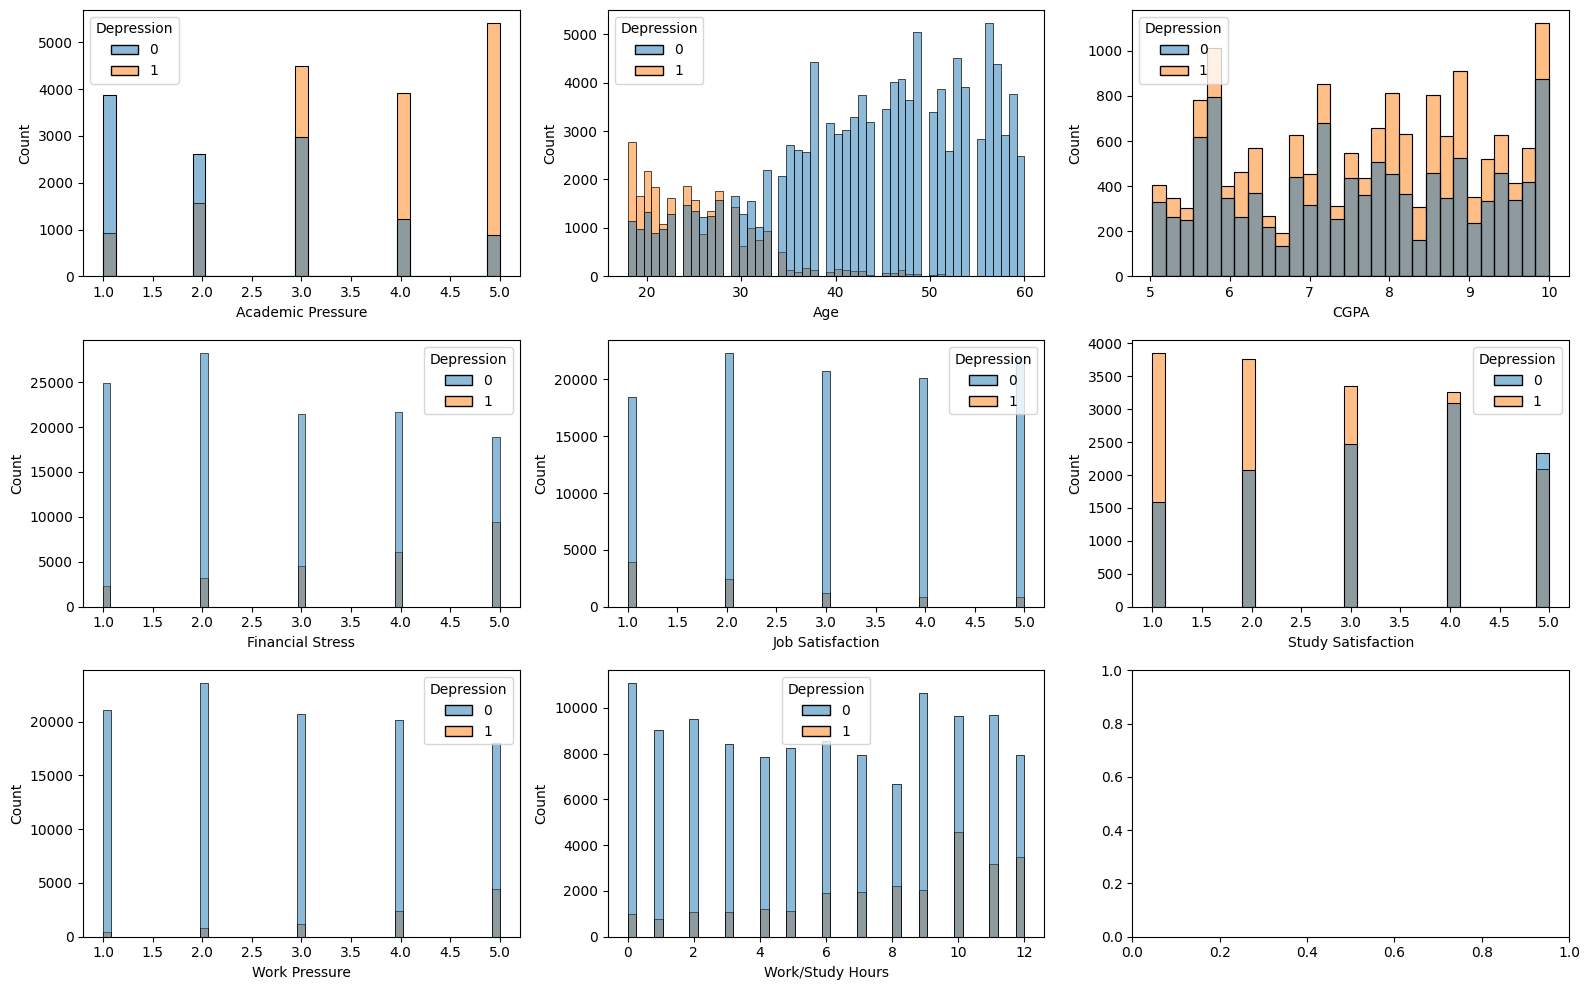

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [27]:
# CGPA가 가장 상관성이 없어 보입니다. mannwhitnry U 검증을 해봅니다.
from scipy.stats import mannwhitneyu
mannwhitneyu(df_train.loc[df_train[target] == 0, 'CGPA'].dropna(), df_train.loc[df_train[target] == 1, 'CGPA'].dropna())

MannwhitneyuResult(statistic=92054552.5, pvalue=0.00032127284999336757)

In [28]:
df_train[X_cont].corr()

,Academic Pressure,Age,CGPA,Financial Stress,Job Satisfaction,Study Satisfaction,Work Pressure,Work/Study Hours
Academic Pressure,1.000000,-0.075956,-0.025195,0.152105,-1.000000,-0.112228,NaN,0.095650
Age,-0.075956,1.000000,0.005129,-0.083589,0.030793,0.008862,-0.098924,-0.118356
CGPA,-0.025195,0.005129,1.000000,0.006398,1.000000,-0.047078,NaN,0.002875
Financial Stress,0.152105,-0.083589,0.006398,1.000000,-0.029160,-0.065001,0.024412,0.036134
Job Satisfaction,-1.000000,0.030793,1.000000,-0.029160,1.000000,-1.000000,-0.036958,-0.029227
Study Satisfaction,-0.112228,0.008862,-0.047078,-0.065001,-1.000000,1.000000,NaN,-0.036934
Work Pressure,NaN,-0.098924,NaN,0.024412,-0.036958,NaN,1.000000,-0.002808
Work/Study Hours,0.095650,-0.118356,0.002875,0.036134,-0.029227,-0.036934,-0.002808,1.000000


In [29]:
def inconsitency_stat():
    return (
        pd.concat([
            df_train['Working Professional or Student'],
            df_train['Academic Pressure'].isna()
        ], axis=1).value_counts(),
        df_train[['Academic Pressure', 'CGPA', 'Study Satisfaction']].isna().sum(axis=1).value_counts(),
        df_train[['Job Satisfaction', 'Work Pressure']].isna().sum(axis=1).value_counts()
    )
s_ws_ac_freq, s_acs_frwq, s_jw = sc.cache_result('inconsitency_stat', inconsitency_stat)
display(s_ws_ac_freq)
display(s_acs_frwq)
display(s_jw)

Working Professional or Student  Academic Pressure
Working Professional             True                 112794
Student                          False                 27892
                                 True                      9
Working Professional             False                     5
Name: count, dtype: int64

3    112799
0     27892
1         7
2         2
Name: count, dtype: int64

0    112777
2     27905
1        18
Name: count, dtype: int64

Working Professional or Student와 Academic Pressure 는 배타적인 성질을 지닌듯 보입니다. 

'Academic Pressure', 'CGPA', 'Study Satisfaction' 와 'Job Satisfaction', 'Work Pressure'의 값의 유무도 배타적으로 보이고 변수의 이름상으로도 배타성이 있습니다.

'Academic Pressure', 'CGPA', 'Study Satisfaction' 의 결측 유무 또한 All or Nothing 으로 보이는데, 간혹 불일치가 있습니다.

'Job Satisfaction', 'Work Pressure'의 결측 유무 또한 All or Nothing 으로 보이는데, 간혹 불일치가 있습니다.

## 일관성이 없는 경우 조사

In [30]:
df_train.loc[
    (df_train['Working Professional or Student'] == 'Student') & 
    (~df_train['Profession_R'].isin(['Unknown', 'Student']))
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
609,Anand,Male,21.0,Ahmedabad,Student,Civil Engineer,5.0,NaN,7.83,1.0,...,11.0,3.0,Yes,1,Ahmedabad,Healthy,Civil Engineer,5-6 hours,MSc,Anand
2105,Shreya,Female,31.0,Vadodara,Student,Architect,5.0,NaN,6.95,3.0,...,8.0,1.0,Yes,1,Vadodara,Moderate,Architect,Less than 5 hours,BSc,Shreya
9483,Vidya,Female,32.0,Kalyan,Student,UX/UI Designer,3.0,NaN,9.60,2.0,...,5.0,3.0,No,1,Kalyan,Moderate,UX/UI Designer,7-8 hours,PhD,Vidya
11470,Anjali,Female,28.0,Ahmedabad,Student,Digital Marketer,5.0,NaN,9.72,3.0,...,10.0,5.0,Yes,1,Ahmedabad,Healthy,Digital Marketer,More than 8 hours,MA,Anjali
12425,Rupak,Male,25.0,Kalyan,Student,Content Writer,5.0,NaN,8.50,2.0,...,0.0,2.0,Yes,1,Kalyan,Moderate,Content Writer,5-6 hours,B.Ed,Rupak
16196,Ivaan,Male,33.0,Jaipur,Student,Architect,2.0,NaN,7.13,4.0,...,2.0,5.0,Yes,1,Jaipur,Moderate,Architect,More than 8 hours,MSc,Ivaan
16959,Vidhi,Female,24.0,Mumbai,Student,Architect,3.0,NaN,8.89,5.0,...,3.0,5.0,Yes,1,Mumbai,Unhealthy,Architect,More than 8 hours,MSc,Vidhi
18291,Ritvik,Male,32.0,Agra,Student,Educational Consultant,3.0,NaN,5.74,4.0,...,3.0,5.0,Yes,1,Agra,Healthy,Educational Consultant,7-8 hours,B.Ed,Ritvik
19226,Rupak,Male,31.0,Rajkot,Student,Teacher,3.0,NaN,7.48,5.0,...,12.0,2.0,Yes,1,Rajkot,Unhealthy,Teacher,5-6 hours,MD,Rupak


In [31]:
df_train.loc[
    (df_train['Working Professional or Student'] == 'Working Professional') & 
    (df_train['Profession_R'] == 'Student')
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
11509,Prisha,Female,22.0,Thane,Working Professional,Student,NaN,3.0,NaN,NaN,...,5.0,2.0,No,0,Thane,Moderate,Student,7-8 hours,B.Com,Prisha
25447,Gaurav,Male,60.0,Pune,Working Professional,Student,NaN,3.0,NaN,NaN,...,8.0,1.0,Yes,0,Pune,Unhealthy,Student,5-6 hours,M.Pharm,Gaurav
73447,Harsha,Male,35.0,Ahmedabad,Working Professional,Student,NaN,4.0,NaN,NaN,...,1.0,3.0,Yes,0,Ahmedabad,Moderate,Student,Less than 5 hours,BSc,Harsha
88617,Ayush,Male,29.0,Srinagar,Working Professional,Student,NaN,4.0,NaN,NaN,...,10.0,1.0,Yes,0,Srinagar,Moderate,Student,5-6 hours,BE,Ayush


In [32]:
df_train.loc[
    df_train[['Academic Pressure', 'CGPA', 'Study Satisfaction']].isna().sum(axis=1).isin([1, 2])
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
17549,Tanya,Female,20.0,Patna,Student,NaN,NaN,NaN,5.55,NaN,...,0.0,3.0,Yes,0,Patna,Moderate,Unknown,5-6 hours,Class 12,Tanya
18344,Shivam,Male,30.0,Faridabad,Student,NaN,5.0,NaN,5.74,NaN,...,0.0,3.0,Yes,1,Faridabad,Unhealthy,Unknown,Less than 5 hours,MCA,Shivam
52737,Aarav,Male,28.0,Vadodara,Student,NaN,3.0,NaN,NaN,4.0,...,12.0,2.0,No,0,Vadodara,Healthy,Unknown,Less than 5 hours,BBA,Aarav
58062,Ishita,Female,32.0,Vadodara,Student,NaN,5.0,NaN,NaN,NaN,...,11.0,5.0,No,1,Vadodara,Unhealthy,Unknown,Less than 5 hours,Class 12,Ishita
60348,Nishant,Male,29.0,Agra,Working Professional,NaN,NaN,NaN,9.72,2.0,...,7.0,2.0,Yes,0,Agra,Moderate,Unknown,5-6 hours,B.Ed,Nishant
102714,Aahana,Female,18.0,Bhopal,Student,NaN,4.0,NaN,5.88,NaN,...,5.0,1.0,No,1,Bhopal,Moderate,Unknown,Less than 5 hours,Class 12,Aahana
110097,Abhinav,Male,34.0,Pune,Student,NaN,1.0,NaN,NaN,5.0,...,10.0,3.0,Yes,0,Pune,Unhealthy,Unknown,Less than 5 hours,M.Ed,Abhinav
122983,Saanvi,Female,30.0,Ghaziabad,Student,NaN,NaN,NaN,5.47,2.0,...,5.0,1.0,No,0,Ghaziabad,Unhealthy,Unknown,Less than 5 hours,B.Com,Saanvi
137013,Vikram,Male,36.0,Varanasi,Student,NaN,NaN,NaN,8.54,3.0,...,8.0,5.0,Yes,1,Varanasi,Moderate,Unknown,More than 8 hours,Class 12,Vikram


In [33]:
df_train.loc[
    df_train[['Job Satisfaction', 'Work Pressure']].isna().sum(axis=1) == 1
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
1428,Rishi,Male,29.0,Srinagar,Student,NaN,3.0,NaN,9.63,3.0,...,8.0,5.0,No,0,Srinagar,Moderate,Unknown,7-8 hours,M.Pharm,Rishi
15846,Shrey,Male,53.0,Vasai-Virar,Working Professional,NaN,NaN,NaN,NaN,NaN,...,12.0,1.0,No,0,Vasai-Virar,Unhealthy,Unknown,More than 8 hours,Class 12,Shrey
25647,Ishwar,Male,57.0,Kalyan,Working Professional,NaN,NaN,1.0,NaN,NaN,...,4.0,1.0,No,0,Kalyan,Unhealthy,Unknown,Less than 5 hours,Class 12,Ishwar
52199,Manan,Male,50.0,Agra,Working Professional,NaN,NaN,4.0,NaN,NaN,...,1.0,3.0,Yes,0,Agra,Unhealthy,Unknown,5-6 hours,Class 12,Manan
55222,Trisha,Female,21.0,Varanasi,Working Professional,NaN,NaN,5.0,NaN,NaN,...,11.0,2.0,Yes,0,Varanasi,Moderate,Unknown,7-8 hours,B.Arch,Trisha
65346,Monika,Female,18.0,Faridabad,Working Professional,NaN,NaN,5.0,NaN,NaN,...,9.0,5.0,No,1,Faridabad,Moderate,Unknown,5-6 hours,Class 12,Monika
70453,Veda,Female,20.0,Ahmedabad,Student,NaN,NaN,NaN,NaN,NaN,...,12.0,3.0,Yes,1,Ahmedabad,Moderate,Unknown,Less than 5 hours,Class 12,Veda
76104,Vanya,Female,20.0,Nashik,Working Professional,NaN,NaN,NaN,NaN,NaN,...,11.0,1.0,No,1,Nashik,Moderate,Unknown,7-8 hours,Class 12,Vanya
85126,Monika,Female,27.0,Kanpur,Working Professional,Mechanical Engineer,NaN,NaN,NaN,NaN,...,10.0,5.0,No,1,Kanpur,Healthy,Mechanical Engineer,5-6 hours,BE,Monika


In [34]:
df_train.loc[
    (df_train['Working Professional or Student'] == 'Student') & 
    (df_train[['Job Satisfaction', 'Work Pressure']].notna().any(axis=1))
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
1428,Rishi,Male,29.0,Srinagar,Student,NaN,3.0,NaN,9.63,3.0,...,8.0,5.0,No,0,Srinagar,Moderate,Unknown,7-8 hours,M.Pharm,Rishi
21880,Aarush,Male,38.0,Chennai,Student,NaN,NaN,5.0,NaN,NaN,...,2.0,3.0,No,0,Chennai,Healthy,Unknown,5-6 hours,Class 12,Aarush
70453,Veda,Female,20.0,Ahmedabad,Student,NaN,NaN,NaN,NaN,NaN,...,12.0,3.0,Yes,1,Ahmedabad,Moderate,Unknown,Less than 5 hours,Class 12,Veda
75007,Aarav,Male,21.0,Lucknow,Student,NaN,NaN,2.0,NaN,NaN,...,3.0,3.0,Yes,0,Lucknow,Moderate,Unknown,7-8 hours,Class 12,Aarav
105773,Anand,Male,18.0,Ahmedabad,Student,NaN,NaN,NaN,NaN,NaN,...,9.0,5.0,No,1,Ahmedabad,Moderate,Unknown,Less than 5 hours,Class 12,Anand
116703,Neil,Male,25.0,Bangalore,Student,NaN,4.0,NaN,9.44,5.0,...,4.0,1.0,No,1,Bangalore,Unhealthy,Unknown,Less than 5 hours,PhD,Neil
129756,Kian,Male,18.0,Rajkot,Student,NaN,NaN,5.0,NaN,NaN,...,9.0,4.0,No,1,Rajkot,Moderate,Unknown,7-8 hours,Class 12,Kian
134830,Aaradhya,Female,24.0,Meerut,Student,NaN,NaN,NaN,NaN,NaN,...,0.0,5.0,No,0,Meerut,Unhealthy,Unknown,More than 8 hours,Class 12,Aaradhya


In [35]:
df_train.loc[
    (df_train['Working Professional or Student'] != 'Student') & 
    (df_train[['Academic Pressure', 'CGPA', 'Study Satisfaction']].notna().any(axis=1))
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
18752,Aarti,Female,18.0,Kalyan,Working Professional,NaN,2.0,NaN,8.14,5.0,...,7.0,1.0,Yes,1,Kalyan,Healthy,Unknown,Less than 5 hours,Class 12,Aarti
41915,Advait,Male,18.0,Kolkata,Working Professional,NaN,4.0,NaN,8.04,3.0,...,1.0,5.0,Yes,1,Kolkata,Healthy,Unknown,5-6 hours,Class 12,Advait
55827,Prachi,Female,19.0,Kalyan,Working Professional,NaN,3.0,NaN,8.11,2.0,...,4.0,4.0,No,1,Kalyan,Unhealthy,Unknown,5-6 hours,Class 12,Prachi
60348,Nishant,Male,29.0,Agra,Working Professional,NaN,NaN,NaN,9.72,2.0,...,7.0,2.0,Yes,0,Agra,Moderate,Unknown,5-6 hours,B.Ed,Nishant
99062,Tanisha,Female,24.0,Surat,Working Professional,Content Writer,4.0,NaN,5.42,4.0,...,1.0,5.0,No,1,Surat,Moderate,Content Writer,Less than 5 hours,B.Ed,Tanisha
101189,Keshav,Male,34.0,Rajkot,Working Professional,NaN,4.0,NaN,8.24,3.0,...,11.0,1.0,No,0,Rajkot,Moderate,Unknown,More than 8 hours,MD,Keshav


In [36]:
def inconsistency_feat(df):
    s_nacnt1 = df[['Academic Pressure', 'CGPA', 'Study Satisfaction']].isna().sum(axis=1).rename('na_cnt1')
    s_nacnt2 = df_train[['Job Satisfaction', 'Work Pressure']].isna().sum(axis=1).rename('na_cnt2')

    proc_list, var_list = list(), list()
    for s, desc,t in [
        (s_nacnt1.astype('int8'), "Student와 관련된 수치의 결측의 수", 'Int8'),
        (s_nacnt2.astype('int8'), "Working Professional 와 관련된 수치의 결측의 수", 'Int8'),
        (s_nacnt1.isin([1, 2]).rename('consitent1'), "na_cnt1에서 결측 여부의 모순 여부", 'Boolean'),
        ((s_nacnt2 == 1).rename('consitent2'), "na_cnt2에서 결측 여부의 모순 여부", 'Boolean'),
        (
            ((df_train['Working Professional or Student'] == 'Student') & (~df_train['Profession_R'].isin(['Unknown', 'Student']))).rename('inconsistent1'),
            "'Working Professional or Student'와 'Profession_R' 사이의 모순 여부", 'Boolean'
        ),
        (
            df_train['Profession_R'].where(df_train['Working Professional or Student'] == 'Working Professional', 'Student').rename('Profession_R2'),
            "'Working Professional or Student'가 Student이면 'Profession_R'을 Student로 치환합니다", 'Categorical'
        )
    ]:
        proc_list.append(s)
        var_list.append(['inconsi', s, desc, t])
    return dproc.get_type_vars(var_list), pd.concat(proc_list, axis=1)

if not 'na_cnt1' in df_train.columns:
    df_inconsistent_var, df_inconsistent = sc.cache_result(
        'Inconsitent_feat', lambda : inconsistency_feat(df_train)
    )
    df_train = df_train.join(df_inconsistent)
    df_var = pd.concat([df_var, df_inconsistent_var])
df_var

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src
Academic Pressure,1.0,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,NaN,org
Age,18.0,60.0,0.0,234500.0,43.5,True,True,True,True,Float32,Float32,NaN,org
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,NaN,org
City,NaN,NaN,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,NaN,org
Degree,NaN,NaN,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,NaN,org
Depression,0.0,1.0,0.0,140700.0,2.0,True,True,True,True,Int8,Int8,Target,org
Dietary Habits,NaN,NaN,9.0,234491.0,23.5,True,True,True,True,Categorical,Categorical,NaN,org
Family History of Mental Illness,NaN,NaN,0.0,234500.0,2.0,True,True,True,True,Categorical,Categorical,NaN,org
Financial Stress,1.0,5.0,4.0,234496.0,5.5,True,True,True,True,Float32,Float32,NaN,org
Gender,NaN,NaN,0.0,234500.0,2.0,True,True,True,True,Categorical,Categorical,NaN,org


In [37]:
# 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work Pressure'], ['Int8', 'Float32', 'Int8', 'Int8', 'Int8', 'Int8'
def get_fillna_mode_proc(s):
    m = s.mode().iloc[0]
    return lambda x: x.fillna(m)

fillna_proc_Financial_Stress = get_fillna_mode_proc(df_train['Financial Stress'])
def fillnas(df):
    proc_list, var_list = list(), list()
    for i, t in zip(['Academic Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work Pressure'], ['Int8', 'Float32', 'Int8', 'Int8', 'Int8', 'Int8']):
        proc_list.append(df[i].fillna(0).astype(t).rename(i + '_FN'))
        var_list.append(('fillna', proc_list[-1], '{}의 결측을 0으로 채운 변수입니다.'.format(i), t))
    proc_list.append(
        fillna_proc_Financial_Stress(df['Financial Stress']).rename('Financial Stress_FN').astype('Int8')
    )
    var_list.append(('fillna', proc_list[-1], 'Financial Stress를 최빈값으로 채웁니다.', 'Int8'))
    return dproc.get_type_vars(var_list), pd.concat(proc_list, axis=1)

if not 'Academic Pressure_FA' in df_train.columns:
    df_fillna_var, df_fillna = sc.cache_result(
        'fillnas', lambda : fillnas(df_train)
    )
    df_train = df_train.join(df_fillna)
    df_var = pd.concat([df_var, df_fillna_var])
df_var

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src
Academic Pressure,1.0,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,NaN,org
Age,18.0,60.0,0.0,234500.0,43.5,True,True,True,True,Float32,Float32,NaN,org
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,NaN,org
City,NaN,NaN,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,NaN,org
Degree,NaN,NaN,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,NaN,org
Depression,0.0,1.0,0.0,140700.0,2.0,True,True,True,True,Int8,Int8,Target,org
Dietary Habits,NaN,NaN,9.0,234491.0,23.5,True,True,True,True,Categorical,Categorical,NaN,org
Family History of Mental Illness,NaN,NaN,0.0,234500.0,2.0,True,True,True,True,Categorical,Categorical,NaN,org
Financial Stress,1.0,5.0,4.0,234496.0,5.5,True,True,True,True,Float32,Float32,NaN,org
Gender,NaN,NaN,0.0,234500.0,2.0,True,True,True,True,Categorical,Categorical,NaN,org


# Feature Analysis with LightGBM

In [53]:
from sklearn.model_selection import StratifiedKFold, train_test_split
import lightgbm as lgb
import sgml

def predict(m, df_valid, X):
    return pd.Series(m.predict_proba(df_valid[X])[:, 1], index=df_valid.index)

def eval_metric(y_true, prds):
    return accuracy_score(y_true[target].sort_index(), prds.sort_index() > 0.5)

def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

## LightGBM baseline

In [39]:
X_lgb_cat = df_var.drop(index=target).query('src == "cat_procs"').index.tolist()
X_lgb_cat

['City_R',
 'Dietary Habits_R',
 'Profession_R',
 'Sleep Duration_R',
 'Degree_R',
 'Name_R']

In [40]:
X_lgb_num_fn = df_var.drop(index=target).query('src == "fillna"').index.to_list()
X_lgb_num_na = df_var.drop(index=target).query('dtype == "Float32" and na > 0').index.to_list()
X_lgb_num = ['Age', 'Work/Study Hours']
X_lgb_bool = df_var.drop(index=target).query('src == "org" and n_unique == 2').index.to_list()
X_lgb_inconsi = df_var.drop(index=target).query('src == "inconsi" and dtype != "Categorical"').index.to_list()
X_lgb_num_fn, X_lgb_num_na, X_lgb_num, X_lgb_bool, X_lgb_inconsi

(['Academic Pressure_FN',
  'CGPA_FN',
  'Study Satisfaction_FN',
  'Job Satisfaction_FN',
  'Work Pressure_FN',
  'Financial Stress_FN'],
 ['Academic Pressure',
  'CGPA',
  'Financial Stress',
  'Job Satisfaction',
  'Study Satisfaction',
  'Work Pressure'],
 ['Age', 'Work/Study Hours'],
 ['Family History of Mental Illness',
  'Gender',
  'Have you ever had suicidal thoughts ?',
  'Working Professional or Student'],
 ['na_cnt1', 'na_cnt2', 'consitent1', 'consitent2', 'inconsistent1'])

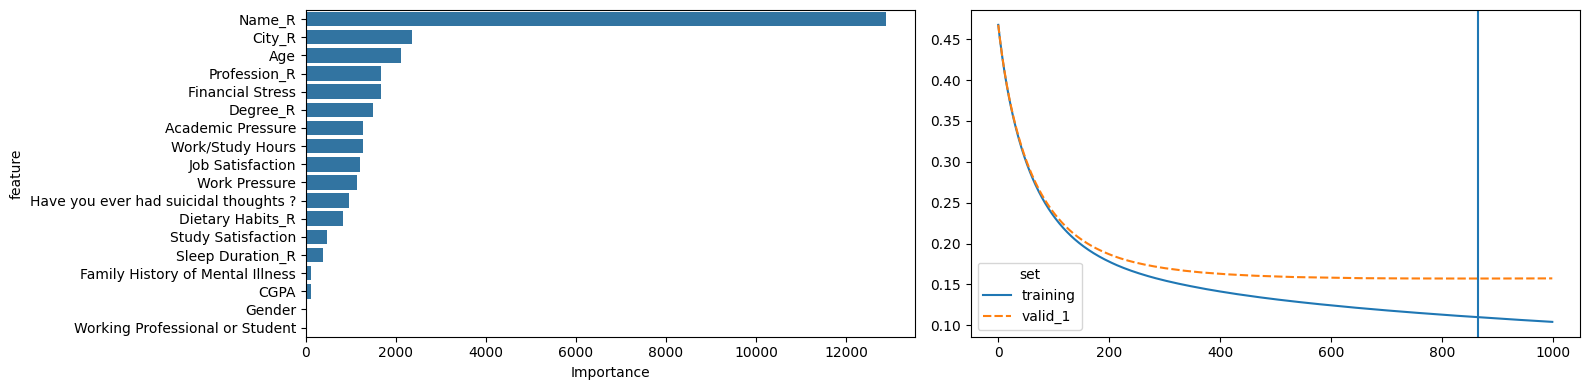

Accuracy, train: 0.95869±0.00047
Accuracy, valid: 0.93830±0.00146


In [117]:
train_score, valid_score, prd, train_result = sc.cache_result(
    'LGBM_Baseline',
    lambda : sgml.cv_model(
            sf, lgb.LGBMClassifier, 
            {'verbose': -1, 'n_estimators': 1000, 'learning_rate': 0.01}, 
            df_train, X_lgb_num_na + X_lgb_num + X_lgb_cat + X_lgb_bool, target, 
            predict, eval_metric,
            train_params = {
                'fit_params': {
                    'categorical_feature': X_lgb_cat,
                    'callbacks': [sgml.LGBMFitProgressbar()]
                },
                'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
                'valid_config_proc': sgml.gb_valid_config,
            },
            result_proc = sgml.lgb_learning_result,
            
        )
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes = axes.flatten()
sns.barplot(
    pd.concat([i[1] for i in train_result], axis=1).mean(axis=1).sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
    x = 'Importance', y = 'feature', ax=axes[0]
)
sns.lineplot(
    pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T, ax=axes[1]
)
axes[1].axvline(pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print_metrics('train', train_score)
print_metrics('valid', valid_score)

## LightGBM, fillna

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

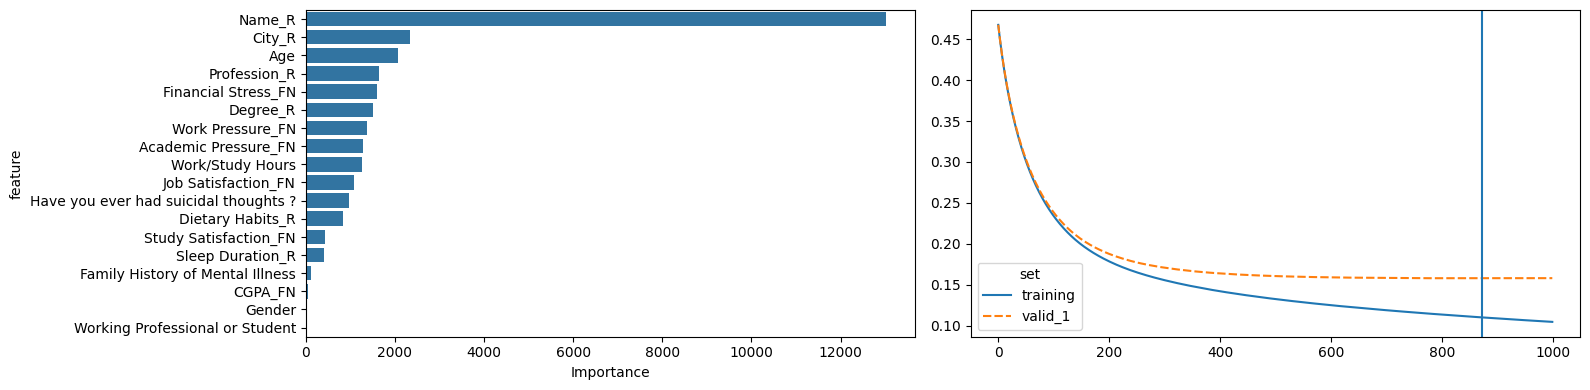

Accuracy, train: 0.95850±0.00033
Accuracy, valid: 0.93810±0.00153


In [119]:
train_score, valid_score, prd, train_result = sc.cache_result(
    'LGBM_fillna',
    lambda : sgml.cv_model(
            sf, lgb.LGBMClassifier, 
            {'verbose': -1, 'n_estimators': 1000, 'learning_rate': 0.01}, 
            df_train, X_lgb_num_fn + X_lgb_num + X_lgb_cat + X_lgb_bool, target, 
            predict, eval_metric,
            train_params = {
                'fit_params': {
                    'categorical_feature': X_lgb_cat,
                    'callbacks': [sgml.LGBMFitProgressbar()]
                },
                'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
                'valid_config_proc': sgml.gb_valid_config,
            },
            result_proc = sgml.lgb_learning_result,
            
        )
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes = axes.flatten()
sns.barplot(
    pd.concat([i[1] for i in train_result], axis=1).mean(axis=1).sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
    x = 'Importance', y = 'feature', ax=axes[0]
)
sns.lineplot(
    pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T, ax=axes[1]
)
axes[1].axvline(pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print_metrics('train', train_score)
print_metrics('valid', valid_score)

## LightGBM fillna, inconsi

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

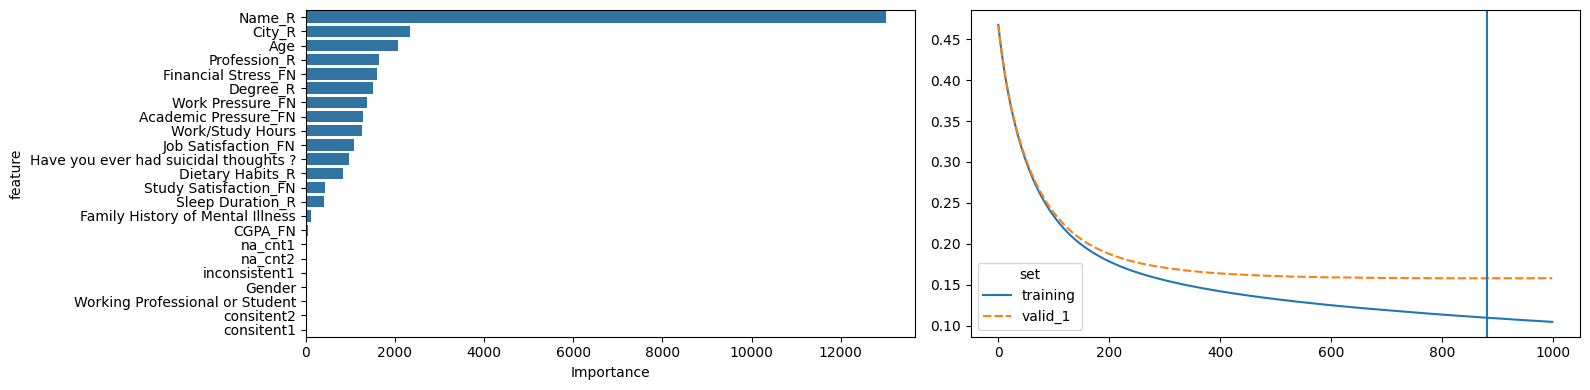

Accuracy, train: 0.95851±0.00034
Accuracy, valid: 0.93807±0.00158


In [120]:
train_score, valid_score, prd, train_result = sc.cache_result(
    'LGBM_fillna_inconsi',
    lambda : sgml.cv_model(
            sf, lgb.LGBMClassifier, 
            {'verbose': -1, 'n_estimators': 1000, 'learning_rate': 0.01}, 
            df_train, X_lgb_num_fn + X_lgb_num + X_lgb_cat + X_lgb_bool + X_lgb_inconsi, target, 
            predict, eval_metric,
            train_params = {
                'fit_params': {
                    'categorical_feature': X_lgb_cat,
                    'callbacks': [sgml.LGBMFitProgressbar()]
                },
                'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
                'valid_config_proc': sgml.gb_valid_config,
            },
            result_proc = sgml.lgb_learning_result,
            
        )
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes = axes.flatten()
sns.barplot(
    pd.concat([i[1] for i in train_result], axis=1).mean(axis=1).sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
    x = 'Importance', y = 'feature', ax=axes[0]
)
sns.lineplot(
    pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T, ax=axes[1]
)
axes[1].axvline(pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print_metrics('train', train_score)
print_metrics('valid', valid_score)

## LightGBM Target Encoding

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

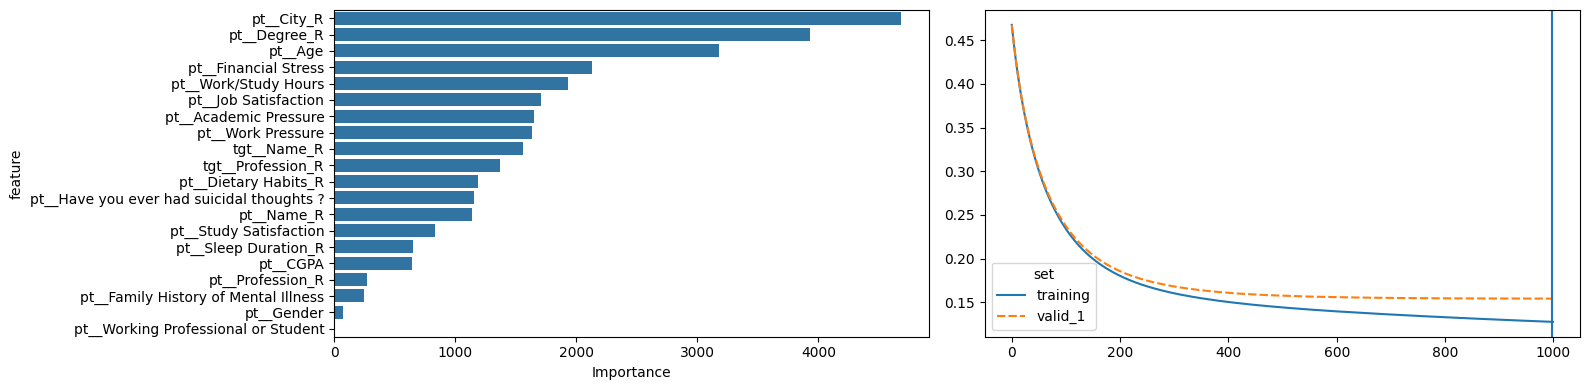

Accuracy, train: 0.94733±0.00037
Accuracy, valid: 0.93900±0.00156


In [44]:
X_lgb_tgt = ['Name_R', 'Profession_R']
X_lgb_cat2 = ['City_R', 'Dietary Habits_R', 'Profession_R', 'Sleep Duration_R', 'Degree_R','Name_R']
X_lgb_cat3 = [i for i in X_lgb_cat2 if i not in X_lgb_tgt]
ct = ColumnTransformer([
    ('tgt', TargetEncoder(), X_lgb_tgt),
    ('pt', 'passthrough', X_lgb_cat2 + X_lgb_num_na + X_lgb_num + X_lgb_bool)
]).set_output(transform="pandas")
train_score, valid_score, prd, train_result = sc.cache_result(
    'LGBM_tgt_enc2',
    lambda : sgml.cv_model(
            sf, lgb.LGBMClassifier, 
            {'verbose': -1, 'n_estimators': 1000, 'learning_rate': 0.01}, 
            df_train, X_lgb_num_na + X_lgb_num + X_lgb_cat2 + X_lgb_bool, target, 
            predict, eval_metric, 
            preprocessor = ct,
            train_params = {
                'fit_params': {
                    'categorical_feature': ['pt__' + i for i in X_lgb_cat3],
                    'callbacks': [sgml.LGBMFitProgressbar()]
                },
                'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
                'valid_config_proc': sgml.gb_valid_config,
            },
            result_proc = sgml.lgb_learning_result,
        )
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes = axes.flatten()
sns.barplot(
    pd.concat([i[1] for i in train_result], axis=1).mean(axis=1).sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
    x = 'Importance', y = 'feature', ax=axes[0]
)
sns.lineplot(
    pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T, ax=axes[1]
)
axes[1].axvline(pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print_metrics('train', train_score)
print_metrics('valid', valid_score)

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

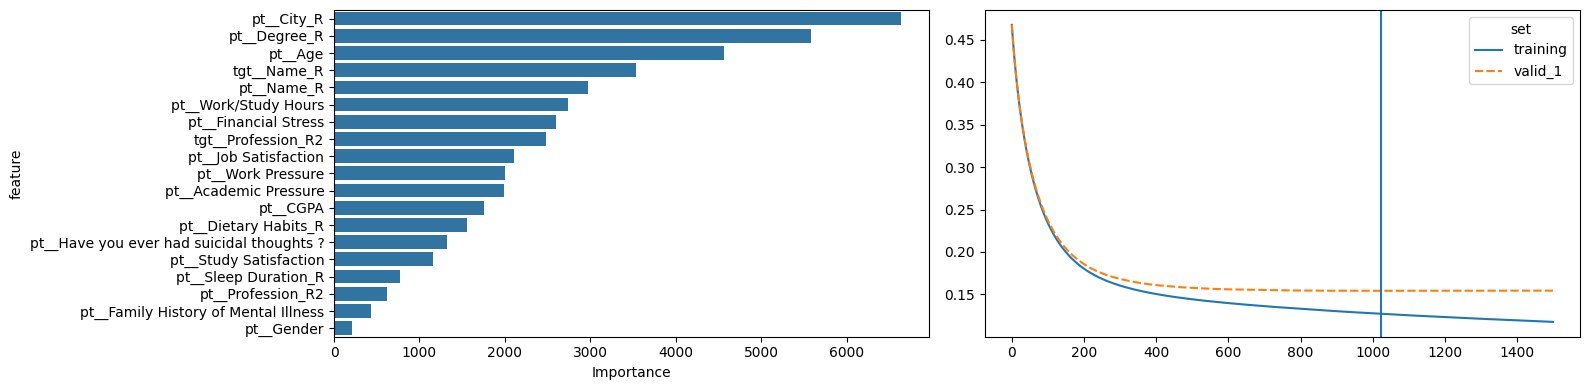

Accuracy, train: 0.95019±0.00026
Accuracy, valid: 0.93922±0.00150


In [49]:
X_lgb_tgt = ['Name_R', 'Profession_R2']
X_lgb_cat2 = ['City_R', 'Dietary Habits_R', 'Profession_R2', 'Sleep Duration_R', 'Degree_R','Name_R']
X_lgb_cat3 = [i for i in X_lgb_cat2 if i not in X_lgb_tgt]
X_lgb_bool2 =['Family History of Mental Illness', 'Gender', 'Have you ever had suicidal thoughts ?']

ct = ColumnTransformer([
    ('tgt', TargetEncoder(), X_lgb_tgt),
    ('pt', 'passthrough', X_lgb_cat2 + X_lgb_num_na + X_lgb_num + X_lgb_bool2)
]).set_output(transform="pandas")
train_score, valid_score, prd, train_result = sc.cache_result(
    'LGBM_tgt_enc3',
    lambda : sgml.cv_model(
            sf, lgb.LGBMClassifier, 
            {'verbose': -1, 'n_estimators': 1500, 'learning_rate': 0.01}, 
            df_train, X_lgb_num_na + X_lgb_num + X_lgb_cat2 + X_lgb_bool2, target, 
            predict, eval_metric, 
            preprocessor = ct,
            train_params = {
                'fit_params': {
                    'categorical_feature': ['pt__' + i for i in X_lgb_cat3],
                    'callbacks': [sgml.LGBMFitProgressbar()]
                },
                'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
                'valid_config_proc': sgml.gb_valid_config,
            },
            result_proc = sgml.lgb_learning_result,
        )
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes = axes.flatten()
sns.barplot(
    pd.concat([i[1] for i in train_result], axis=1).mean(axis=1).sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
    x = 'Importance', y = 'feature', ax=axes[0]
)
sns.lineplot(
    pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T, ax=axes[1]
)
axes[1].axvline(pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print_metrics('train', train_score)
print_metrics('valid', valid_score)

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

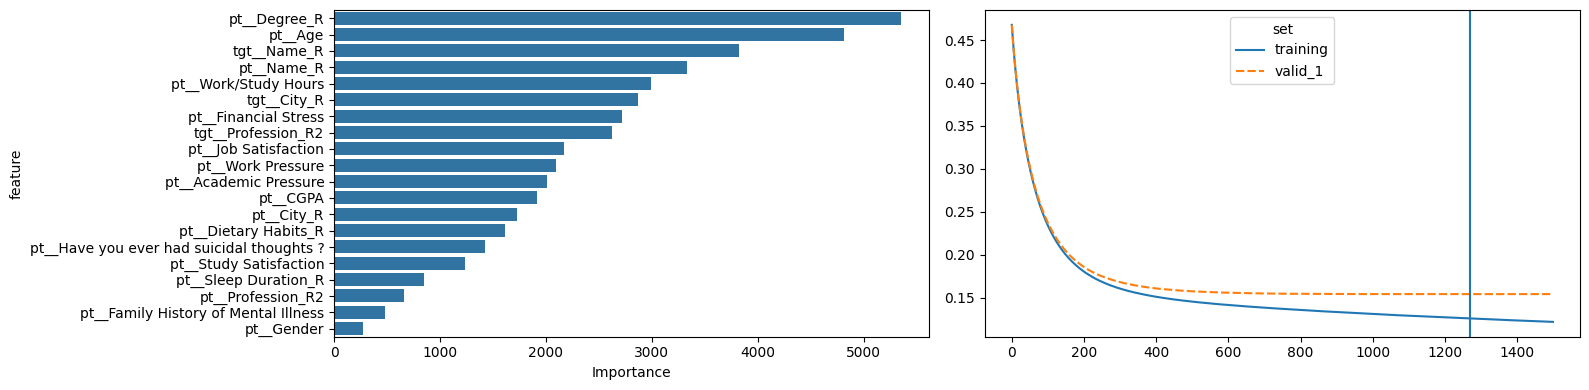

Accuracy, train: 0.94775±0.00021
Accuracy, valid: 0.93920±0.00160


In [51]:
X_lgb_tgt = ['Name_R', 'Profession_R2', 'City_R']
X_lgb_cat2 = ['City_R', 'Dietary Habits_R', 'Profession_R2', 'Sleep Duration_R', 'Degree_R','Name_R']
X_lgb_cat3 = [i for i in X_lgb_cat2 if i not in X_lgb_tgt]
X_lgb_bool2 =['Family History of Mental Illness', 'Gender', 'Have you ever had suicidal thoughts ?']

ct = ColumnTransformer([
    ('tgt', TargetEncoder(), X_lgb_tgt),
    ('pt', 'passthrough', X_lgb_cat2 + X_lgb_num_na + X_lgb_num + X_lgb_bool2)
]).set_output(transform="pandas")
train_score, valid_score, prd, train_result = sc.cache_result(
    'LGBM_tgt_enc4',
    lambda : sgml.cv_model(
            sf, lgb.LGBMClassifier, 
            {'verbose': -1, 'n_estimators': 1500, 'learning_rate': 0.01}, 
            df_train, X_lgb_num_na + X_lgb_num + X_lgb_cat2 + X_lgb_bool2, target, 
            predict, eval_metric, 
            preprocessor = ct,
            train_params = {
                'fit_params': {
                    'categorical_feature': ['pt__' + i for i in X_lgb_cat3],
                    'callbacks': [sgml.LGBMFitProgressbar()]
                },
                'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
                'valid_config_proc': sgml.gb_valid_config,
            },
            result_proc = sgml.lgb_learning_result,
        )
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes = axes.flatten()
sns.barplot(
    pd.concat([i[1] for i in train_result], axis=1).mean(axis=1).sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
    x = 'Importance', y = 'feature', ax=axes[0]
)
sns.lineplot(
    pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T, ax=axes[1]
)
axes[1].axvline(pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print_metrics('train', train_score)
print_metrics('valid', valid_score)

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

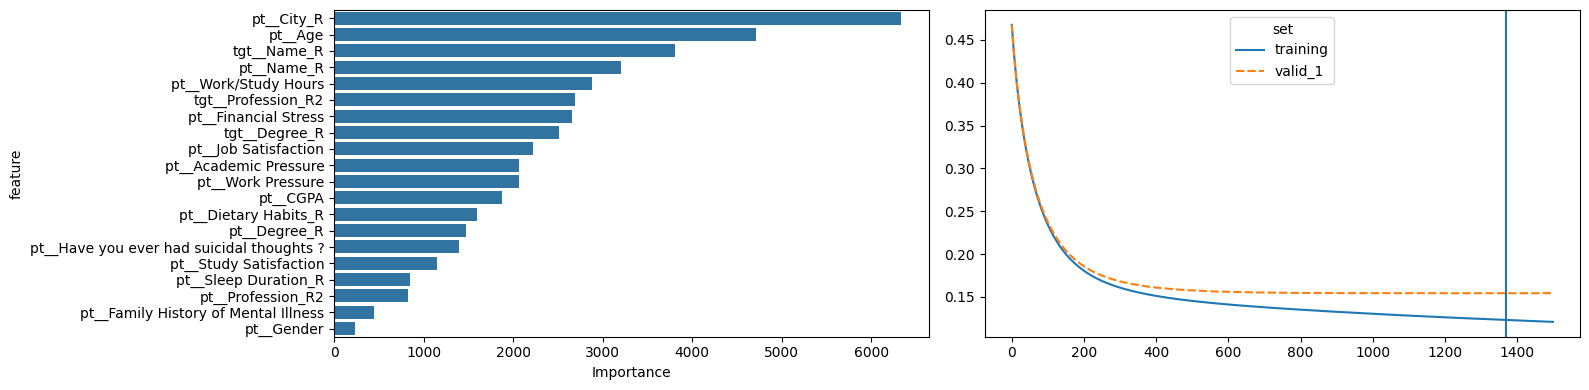

Accuracy, train: 0.94832±0.00027
Accuracy, valid: 0.93933±0.00134


In [52]:
X_lgb_tgt = ['Name_R', 'Profession_R2', 'Degree_R']
X_lgb_cat2 = ['City_R', 'Dietary Habits_R', 'Profession_R2', 'Sleep Duration_R', 'Degree_R','Name_R']
X_lgb_cat3 = [i for i in X_lgb_cat2 if i not in X_lgb_tgt]
X_lgb_bool2 =['Family History of Mental Illness', 'Gender', 'Have you ever had suicidal thoughts ?']

ct = ColumnTransformer([
    ('tgt', TargetEncoder(), X_lgb_tgt),
    ('pt', 'passthrough', X_lgb_cat2 + X_lgb_num_na + X_lgb_num + X_lgb_bool2)
]).set_output(transform="pandas")
train_score, valid_score, prd, train_result = sc.cache_result(
    'LGBM_tgt_enc5',
    lambda : sgml.cv_model(
            sf, lgb.LGBMClassifier, 
            {'verbose': -1, 'n_estimators': 1500, 'learning_rate': 0.01}, 
            df_train, X_lgb_num_na + X_lgb_num + X_lgb_cat2 + X_lgb_bool2, target, 
            predict, eval_metric, 
            preprocessor = ct,
            train_params = {
                'fit_params': {
                    'categorical_feature': ['pt__' + i for i in X_lgb_cat3],
                    'callbacks': [sgml.LGBMFitProgressbar()]
                },
                'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
                'valid_config_proc': sgml.gb_valid_config,
            },
            result_proc = sgml.lgb_learning_result,
        ), rerun=True
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes = axes.flatten()
sns.barplot(
    pd.concat([i[1] for i in train_result], axis=1).mean(axis=1).sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
    x = 'Importance', y = 'feature', ax=axes[0]
)
sns.lineplot(
    pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T, ax=axes[1]
)
axes[1].axvline(pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print_metrics('train', train_score)
print_metrics('valid', valid_score)

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

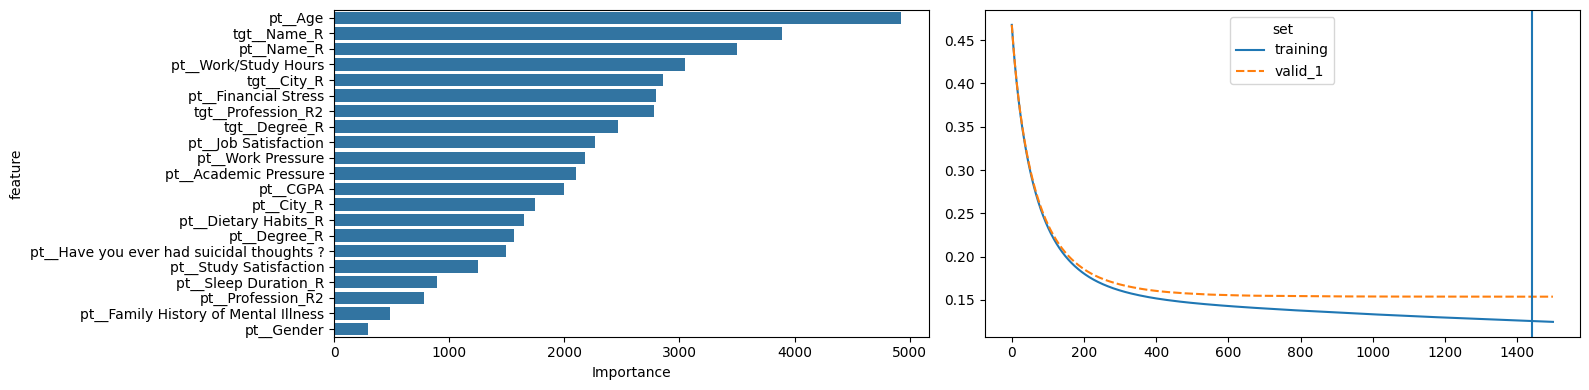

Accuracy, train: 0.94632±0.00041
Accuracy, valid: 0.93952±0.00157


In [58]:
X_lgb_tgt = ['Name_R', 'Profession_R2', 'City_R', 'Degree_R']
X_lgb_cat2 = ['City_R', 'Dietary Habits_R', 'Profession_R2', 'Sleep Duration_R', 'Degree_R','Name_R']
X_lgb_cat3 = [i for i in X_lgb_cat2 if i not in X_lgb_tgt]
X_lgb_bool2 =['Family History of Mental Illness', 'Gender', 'Have you ever had suicidal thoughts ?']

ct = ColumnTransformer([
    ('tgt', TargetEncoder(), X_lgb_tgt),
    ('pt', 'passthrough', X_lgb_cat2 + X_lgb_num_na + X_lgb_num + X_lgb_bool2)
]).set_output(transform="pandas")
train_score, valid_score, prd, train_result = sc.cache_result(
    'LGBM_tgt_enc',
    lambda : sgml.cv_model(
            sf, lgb.LGBMClassifier, 
            {'verbose': -1, 'n_estimators': 1500, 'learning_rate': 0.01}, 
            df_train, X_lgb_num_na + X_lgb_num + X_lgb_cat2 + X_lgb_bool2, target, 
            predict, eval_metric, 
            preprocessor = ct,
            train_params = {
                'fit_params': {
                    'categorical_feature': ['pt__' + i for i in X_lgb_cat3],
                    'callbacks': [sgml.LGBMFitProgressbar()]
                },
                'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
                'valid_config_proc': sgml.gb_valid_config,
            },
            result_proc = sgml.lgb_learning_result,
        )
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes = axes.flatten()
sns.barplot(
    pd.concat([i[1] for i in train_result], axis=1).mean(axis=1).sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
    x = 'Importance', y = 'feature', ax=axes[0]
)
sns.lineplot(
    pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T, ax=axes[1]
)
axes[1].axvline(pd.concat([i[0] for i in train_result], axis=1).T.groupby(level=1).mean().T['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print_metrics('train', train_score)
print_metrics('valid', valid_score)

'Name_R', 'Profession_R2', 'City_R', 'Degree_R' 의 TargetEncoding에 효과를 볼 수 있었습니다.

## Error Analysis

In [59]:
X_lgb_tgt = ['Name_R', 'Profession_R2', 'City_R', 'Degree_R']
X_lgb_cat2 = ['City_R', 'Dietary Habits_R', 'Profession_R2', 'Sleep Duration_R', 'Degree_R','Name_R']
X_lgb_cat3 = [i for i in X_lgb_cat2 if i not in X_lgb_tgt]
X_lgb_bool2 =['Family History of Mental Illness', 'Gender', 'Have you ever had suicidal thoughts ?']

ct = ColumnTransformer([
    ('tgt', TargetEncoder(), X_lgb_tgt),
    ('pt', 'passthrough', X_lgb_cat2 + X_lgb_num_na + X_lgb_num + X_lgb_bool2)
]).set_output(transform="pandas")
train_score, valid_score, prd, train_result = sc.cache_result(
    'LGBM_err_analysis',
    lambda : sgml.cv_model(
            sf, lgb.LGBMClassifier, 
            {'verbose': -1, 'n_estimators': 1500, 'learning_rate': 0.01}, 
            df_train, X_lgb_num_na + X_lgb_num + X_lgb_cat2 + X_lgb_bool2, target, 
            predict, eval_metric, 
            preprocessor = ct,
            train_params = {
                'fit_params': {
                    'categorical_feature': ['pt__' + i for i in X_lgb_cat3],
                    'callbacks': [sgml.LGBMFitProgressbar()]
                }
            },
            result_proc = sgml.lgb_learning_result,
        ), rerun=True
)
print_metrics('train', train_score)
print_metrics('valid', valid_score)

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy, train: 0.94637±0.00042
Accuracy, valid: 0.93968±0.00170


In [65]:
df_train.loc[
    (prd.sort_index() >= 0.5).astype('int') != df_train[target]
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,consitent1,consitent2,inconsistent1,Profession_R2,Academic Pressure_FN,CGPA_FN,Study Satisfaction_FN,Job Satisfaction_FN,Work Pressure_FN,Financial Stress_FN
id,,,,,,,,,,,,,,,,,,,,,
15,Aditi,Female,23.0,Patna,Working Professional,Marketing Manager,NaN,2.0,NaN,NaN,...,False,False,False,Marketing Manager,0,0.0,0,2,2,4
27,Aarav,Male,50.0,Ghaziabad,Working Professional,HR Manager,NaN,5.0,NaN,NaN,...,False,False,False,HR Manager,0,0.0,0,3,5,5
32,Chhavi,Female,25.0,Jaipur,Student,NaN,4.0,NaN,8.13,3.0,...,False,False,False,Student,4,8.13,3,0,0,1
50,Raunak,Male,21.0,Pune,Working Professional,NaN,NaN,4.0,NaN,NaN,...,False,False,False,Unknown,0,0.0,0,5,4,5
90,Ayush,Male,24.0,Chennai,Working Professional,Teacher,NaN,4.0,NaN,NaN,...,False,False,False,Teacher,0,0.0,0,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140666,Abhishek,Male,18.0,Vadodara,Working Professional,NaN,NaN,5.0,NaN,NaN,...,False,False,False,Unknown,0,0.0,0,4,5,5
140669,Aditi,Female,20.0,Indore,Student,NaN,3.0,NaN,7.72,5.0,...,False,False,False,Student,3,7.72,5,0,0,1
140681,Pratham,Male,23.0,Srinagar,Student,NaN,3.0,NaN,6.00,2.0,...,False,False,False,Student,3,6.0,2,0,0,4


In [68]:
((prd.sort_index() >= 0.5).astype('int') == df_train[target]).mean()

0.939680170575693